In [63]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

## Helper functions

1. `validity_mask`: Returns a mask for the array containing 1.0 and 0.0 for valid and invalid positions respectively. Invalid pixels outside (0,1).
2. `unnormalize`: Returns an unnormalized image.

In [64]:
def validity_mask(test_array):
    test_array = test_array + lr * test_array.grad.data
    zero_mask = test_array[0] > 0
    ones_mask = test_array[0] < 1
    return ~(~zero_mask + ~ones_mask)

def unnormalize(inp, means, stds):
    out = inp.new(*inp.size())
    for channel in range(len(means)):
        out[channel,:,:] = inp[channel,:,:] * stds[channel] + means[channel]
    return out

## Calculate gradients and update image

1. For class `strawberry: 949`, we compute $\dfrac{\partial f_{949}}{\partial x}$ by backpropagation.
> `backward()`
Computes the gradient of current tensor w.r.t. graph leaves.
The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying gradient. It should be a tensor of matching type and location, that contains the gradient of the differentiated function w.r.t. self.

2. This is how much the **output** for class `strawberry` changes according to the input.

In [65]:
def attack(path):
    lr = 1
    target_class = 949

    img = PIL.Image.open(path)
    resnet18 = models.resnet18(pretrained=True).eval()

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    weights = torch.zeros(1000)
    weights[target_class] = 1.0

    loss_func = nn.CrossEntropyLoss(weight=weights)

    # Visualize original image
    img = transform(img)
    orig = unnormalize(img, means, stds)
    #transforms.ToPILImage()(orig).show()

    inp = img[None]
    pred = resnet18(inp).argmax(dim=1, keepdim=True)
    first_pred = pred

    while pred.item() != target_class:
        inp = torch.autograd.Variable(inp, requires_grad=True)
        output = resnet18(inp)
        pred = output.argmax(dim=1, keepdim=True)

        # Select the class output corresponding
        # to the target class. Compute entire
        # graph gradient w.r.t class output.
        class_output = output[0][target_class]
        class_output.backward()

        # Obtain the validity mask for the input
        mask = validity_mask(inp)

        # Update the input with the gradients
        # at positions specified by the mask
        inp = inp + lr * mask.float() * inp.grad.data

        print("Current result: {} | Target result: {} | Output: {}"
            .format(pred.item(), target_class, class_output))

    # Visualize changed image
    new_img = inp[0]
    new_img = unnormalize(new_img, means, stds)
    # transforms.ToPILImage()(new_img).show()
    pred = resnet18(inp).argmax(dim=1, keepdim=True)

    # Visualize difference
    # transforms.ToPILImage()(new_img - orig).show()
    
    return first_pred, pred, orig, new_img

Current result: 385 | Target result: 949 | Output: -4.526203155517578
Current result: 965 | Target result: 949 | Output: -2.0388572216033936
Current result: 965 | Target result: 949 | Output: -0.3052966594696045
Current result: 965 | Target result: 949 | Output: 1.3985785245895386
Current result: 965 | Target result: 949 | Output: 3.349835157394409
Current result: 965 | Target result: 949 | Output: 4.857926845550537
Current result: 965 | Target result: 949 | Output: 6.188236236572266
Current result: 965 | Target result: 949 | Output: 7.021860599517822
Current result: 965 | Target result: 949 | Output: 9.194659233093262
Current result: 949 | Target result: 949 | Output: 11.390204429626465


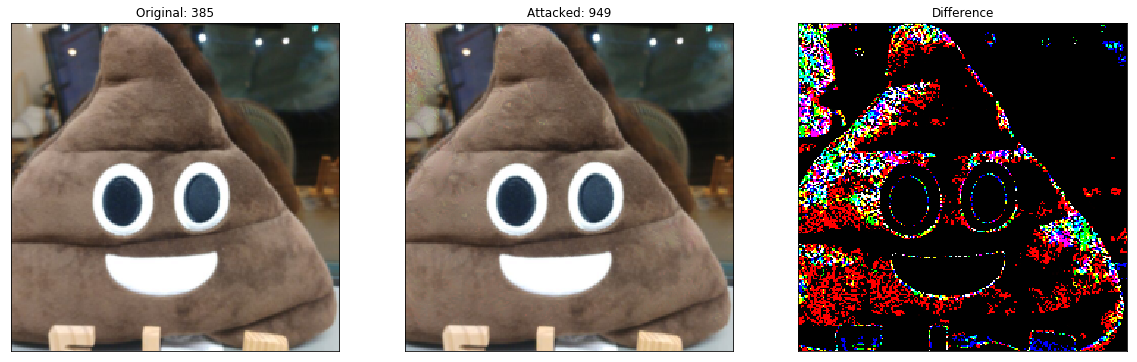

Current result: 863 | Target result: 949 | Output: -0.8258538842201233
Current result: 863 | Target result: 949 | Output: 0.3428635001182556
Current result: 863 | Target result: 949 | Output: 1.2861579656600952
Current result: 863 | Target result: 949 | Output: 2.1860132217407227
Current result: 816 | Target result: 949 | Output: 3.075025796890259
Current result: 816 | Target result: 949 | Output: 3.9028167724609375
Current result: 816 | Target result: 949 | Output: 4.694350242614746
Current result: 816 | Target result: 949 | Output: 5.5475287437438965
Current result: 816 | Target result: 949 | Output: 6.395444869995117
Current result: 816 | Target result: 949 | Output: 7.247608184814453
Current result: 816 | Target result: 949 | Output: 8.01882266998291
Current result: 816 | Target result: 949 | Output: 8.927409172058105
Current result: 816 | Target result: 949 | Output: 9.761921882629395
Current result: 816 | Target result: 949 | Output: 10.743388175964355
Current result: 949 | Targe

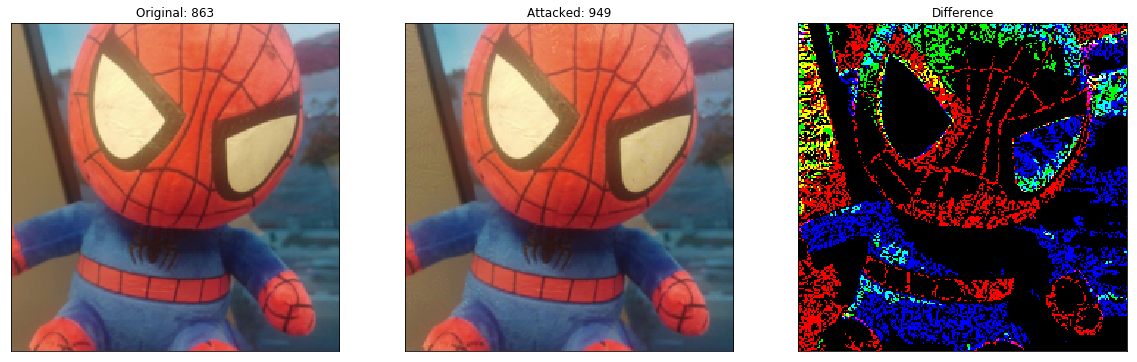

Current result: 850 | Target result: 949 | Output: 1.5966994762420654
Current result: 850 | Target result: 949 | Output: 7.68373966217041
Current result: 951 | Target result: 949 | Output: 13.076476097106934
Current result: 951 | Target result: 949 | Output: 17.032514572143555
Current result: 951 | Target result: 949 | Output: 19.93613052368164
Current result: 951 | Target result: 949 | Output: 21.609846115112305
Current result: 951 | Target result: 949 | Output: 24.863500595092773
Current result: 949 | Target result: 949 | Output: 27.819570541381836


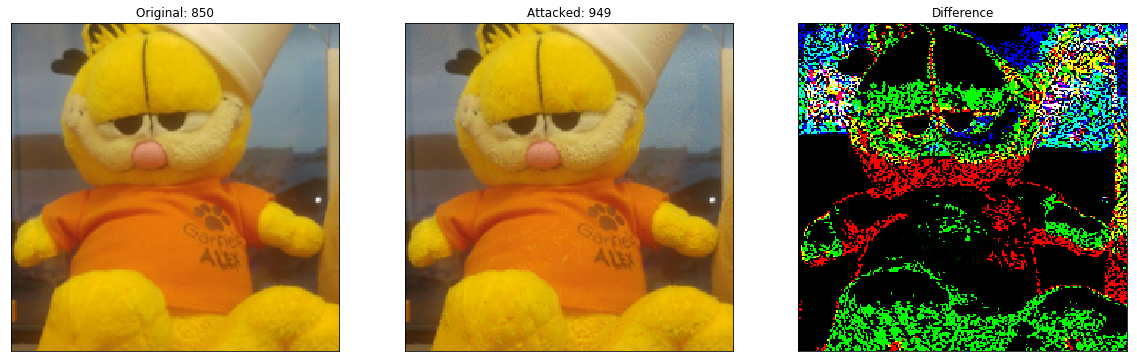

In [67]:
def prep(img):
    return np.transpose(np.swapaxes(img.detach(),0,2), axes=(1,0,2))

def show_attack(first_pred, pred, orig, new_img):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.xticks([]), plt.yticks([])
    plt.title("Original: {}".format(first_pred.item()))
    plt.imshow(prep(orig))
    plt.subplot(132)
    plt.xticks([]), plt.yticks([])
    plt.title("Attacked: {}".format(pred.item()))
    plt.imshow(prep(new_img))
    plt.subplot(133)
    plt.xticks([]), plt.yticks([])
    plt.title("Difference")
    pre = prep(new_img) - prep(orig)
    pre[np.where(pre<0)] = 1
    plt.imshow(pre)
    plt.show()

for pic in ['mrshout2.jpg', 'mrhero.jpg', 'mrallfine.jpg']:
    first_pred, pred, orig, new_img = attack(pic)
    show_attack(first_pred, pred, orig, new_img)